In [150]:
import cv2
import numpy as np
from PIL import Image


class RandomTransform(object):

    def __init__(self, rotation_range=10, zoom_range=0.05, shift_range=0.05, hue_range=7, saturation_range=0.2,
                 brightness_range=80, flip_probability=0.5):
        """
        :param rotation_range: Range within the image gets rotated randomly
        :param zoom_range: Range within the image gets zoomed randomly
        :param shift_range: Range within the image gets shifted randomly
        :param hue_range: Range within the image's hue gets shifted randomly
        :param saturation_range: Range within the image's saturation gets shifted randomly
        :param brightness_range: Range within the image's brightness gets shifted randomly
        :param flip_probability: Probability of a random flip of the image
        """
        self.rotation_range = rotation_range
        self.zoom_range = zoom_range
        self.shift_range = shift_range
        self.hue_range = hue_range
        self.saturation_range = saturation_range
        self.brightness_range = brightness_range
        self.flip_probability = flip_probability

    def __call__(self, image):
        rotation = np.random.uniform(-self.rotation_range, self.rotation_range)
        scale = np.random.uniform(1 - self.zoom_range, 1 + self.zoom_range)
        x_shift = np.random.uniform(-self.shift_range, self.shift_range) * 256
        y_shift = np.random.uniform(-self.shift_range, self.shift_range) * 256

        trans = cv2.getRotationMatrix2D((256 // 2, 256 // 2), rotation, scale)
        trans[:, 2] += (x_shift, y_shift)
        image = cv2.warpAffine(image, trans, (256, 256), borderMode=cv2.BORDER_REPLICATE)

        if np.random.random() < self.flip_probability:
                image = image[:, ::-1]

        h, s, v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

        h += np.random.uniform(-self.hue_range, self.hue_range)
        s += np.random.uniform(-self.saturation_range, self.saturation_range)
        v += np.random.uniform(-self.brightness_range, self.brightness_range)

        return cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)


class RandomWarp(object):

    def __init__(self, warp_factor=5):
        """
        :param warp_factor: The warping factor
        """
        self.warp_factor = warp_factor

    def __call__(self, image):
        H, W, C = image.shape

        # Generate warped image
        # Create coarse mapping with the size of the image
        grid_size = 5
        grid = (grid_size, grid_size)
        range_x = np.linspace(0, W, grid_size)
        range_y = np.linspace(0, H, grid_size)
        mapx, mapy = np.meshgrid(range_x, range_y)
        # Add randomness to the mapping -> warps image
        warp_mapx = mapx + np.random.normal(size=grid, scale=self.warp_factor)
        warp_mapy = mapy + np.random.normal(size=grid, scale=self.warp_factor)
        # Scale coarse mapping to fine mapping
        interp_mapx = cv2.resize(warp_mapx, (H, W)).astype('float32')
        interp_mapy = cv2.resize(warp_mapy, (H, W)).astype('float32')
        # Apply warping
        warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

        # Generate target image
        # Define points correspondences between warped source map and linear destination map
        src_points = np.vstack([warp_mapx.ravel(), warp_mapy.ravel()]).T
        dst_points = np.vstack([mapx.ravel(), mapy.ravel()]).T
        # Umeyama transformation: Calculate affine mapping between two sets of point correspondences
        mat = umeyama(src_points, dst_points, True)[0:2]
        # Apply Umeyama transformation
        target_image = cv2.warpAffine(image, mat, (W, H))

        # Warping makes border regions almost completely black
        # Create mapping larger than image and cut border regions (outer 10% of the image)
        warped_image = warped_image[W // 10:W // 10 * 9, H // 10:H // 10 * 9]
        print("warped")
        return warped_image, target_image


class Resize(object):

    def __init__(self, resolution=(256,256)):
        """
        :param resolution: Resolution to scale the image to
        """
        self.resolution = resolution

    def __call__(self, image):
        return cv2.resize(image, self.resolution)
    
class ResizeTuple(object):

    def __init__(self, resolution=(256,256)):
        """
        :param resolution: Resolution to scale the image to
        """
        self.resolution = resolution

    def __call__(self, image_tuple):
        return cv2.resize(image_tuple[0], self.resolution), cv2.resize(image_tuple[1], self.resolution)


class ToPIL(object):

    def __call__(self, image_tuple):
        return Image.fromarray(image_tuple[0].astype(np.uint8)), Image.fromarray(image_tuple[1].astype(np.uint8))


class FromPIL(object):

    def __call__(self, image):
        return np.asarray(image).astype(np.float32)

In [140]:
## License (Modified BSD)
## Copyright (C) 2011, the scikit-image team All rights reserved.
##
## Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
##
## Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
## Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
## Neither the name of skimage nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.
## THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# umeyama function from scikit-image/skimage/transform/_geometric.py

import numpy as np


def umeyama(src, dst, estimate_scale):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [157]:
from torchvision.transforms import Compose, ToTensor

In [158]:
import os
import cv2
import numpy as np
from PIL import Image

from torchvision.datasets import ImageFolder


class ImageDataset(ImageFolder):

    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)
        self.transform = Compose([
            FromPIL(),
            Resize(),
            RandomTransform(),
            RandomWarp(),
            ResizeTuple((64,64)),
            ToPIL(),
            ToTensor()
        ])

    def __len__(self):
        pass

    def __getitem__(self, i):
        res = super().__getitem__(i)
        return res
    

    def save_processed_images(self, path):
        for idx, img in enumerate(self.imgs):
            cv2.imwrite(os.path.join(path, str(idx) + ".jpg"), img)

In [159]:
d = ImageDataset("./img")

In [160]:
img = d.__getitem__(0)

warped


TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

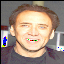

In [155]:
img[0][1]

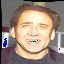

In [156]:
img[0][0]